In [ ]:
#PCA

In [1]:
import pandas as pd
import numpy as np
import pathlib
import glob
import datetime as dt

from statsmodels.tsa.ar_model import AutoReg as AR
from sklearn.metrics import mean_squared_error as mse
import datetime as dt
import warnings

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_excel("headline_cpi_ver2.xlsx")


In [3]:
#Level 0
level0_df = df[df['display_level']==0][["month","item_name","value"]]
level0_df = level0_df[["month","item_name","value"]].pivot_table(index = "month", columns="item_name",values="value")
cpi_values = level0_df[['All items']]

In [4]:
variance_threshold = 0.5

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\297131810.py:66: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 3.129722195445062


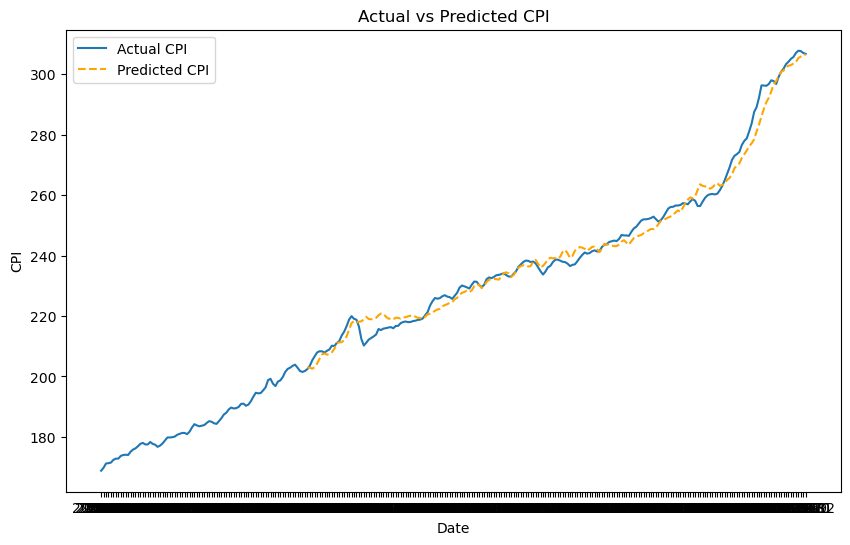

In [5]:


def choose_num_components(data, variance_threshold):
    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data)

    # Apply PCA
    pca = PCA()
    pca.fit(standardized_data)

    # Calculate cumulative explained variance ratio
    explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)

    # Determine the number of components to capture at least 'variance_threshold' of the variance
    num_components = np.argmax(explained_variance_ratio_cumsum >= variance_threshold) + 1

    return num_components

def sliding_window_pca_forecast(X, y, window_size, forecast_horizon, num_components):
    predictions = pd.DataFrame()  # Use a Series with correct index
    
    for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
        # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions = pd.concat([predictions,forecast_predictions])
    
    return predictions


cpi = level0_df[["All items"]]
cpi_indicators = level0_df[[ 'Apparel', 'Education and communication',
       'Food and beverages', 'Housing', 'Medical care',
       'Other goods and services', 'Recreation']]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

In [61]:
#Level 1
level1_df = df[df['display_level']==1][["month","item_name","value"]]
level1_df = level1_df[["month","item_name","value"]].pivot_table(index = "month", columns="item_name",values="value")
level1_df = level1_df.fillna(0)

C:\Users\nguye\AppData\Local\Temp\ipykernel_1868\3536702734.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 2.9665048271460783


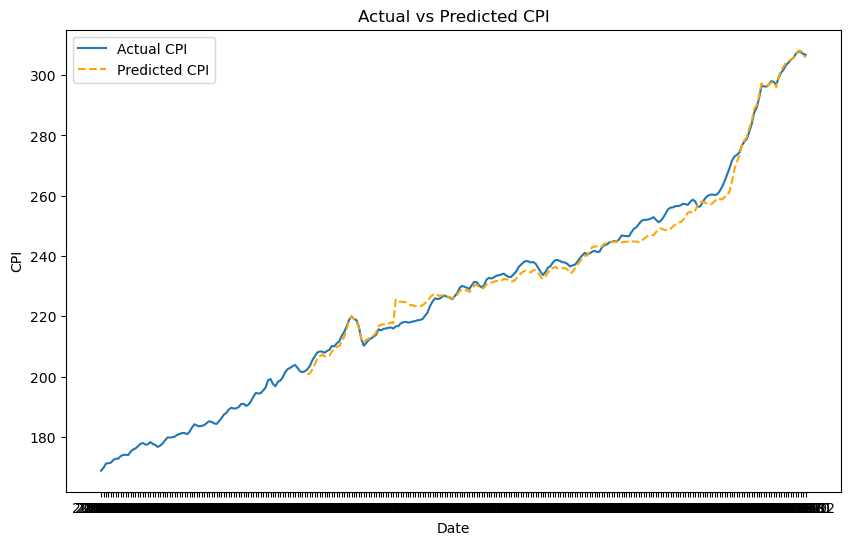

In [105]:
cpi = level0_df[["All items"]]
cpi_indicators = level1_df[level1_df.columns]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

In [62]:
#Level 2
level2_df = df[df['display_level']==2][["month","item_name","value"]]
level2_df = level2_df[["month","item_name","value"]].pivot_table(index = "month", columns="item_name",values="value")
level2_df = level2_df.fillna(0)

cpi_indicators = level2_df[level2_df.columns]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

TypeError: choose_num_components() missing 1 required positional argument: 'variance_threshold'

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\685111365.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 2.908748750640044


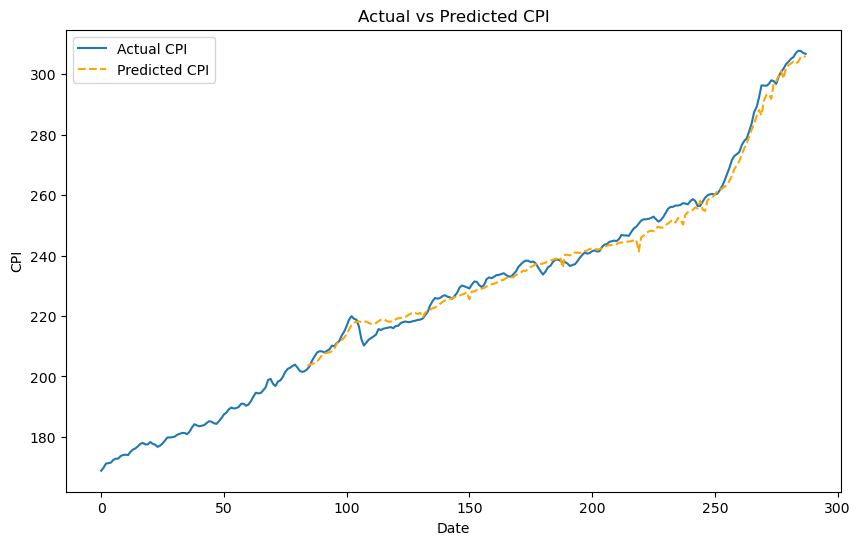

In [63]:
#Level 3
level3_df = df[df['display_level']==3][["month","item_name","value"]]
level3_df = level3_df[["month","item_name","value"]].pivot_table(index = "month", columns="item_name",values="value")
level3_df = level3_df.fillna(0)

cpi_indicators = level3_df[level3_df.columns]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

In [83]:
#Level 4
level4_df = df[df['display_level']==4][["month","item_name","value"]]
level4_df = level4_df[["month","item_name","value"]].pivot_table(index = "month", columns="item_name",values="value")
level4_df = level4_df.fillna(0)

cpi_indicators = level4_df[level4_df.columns]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

TypeError: choose_num_components() missing 1 required positional argument: 'variance_threshold'

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\3513628907.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 5.693730763757793


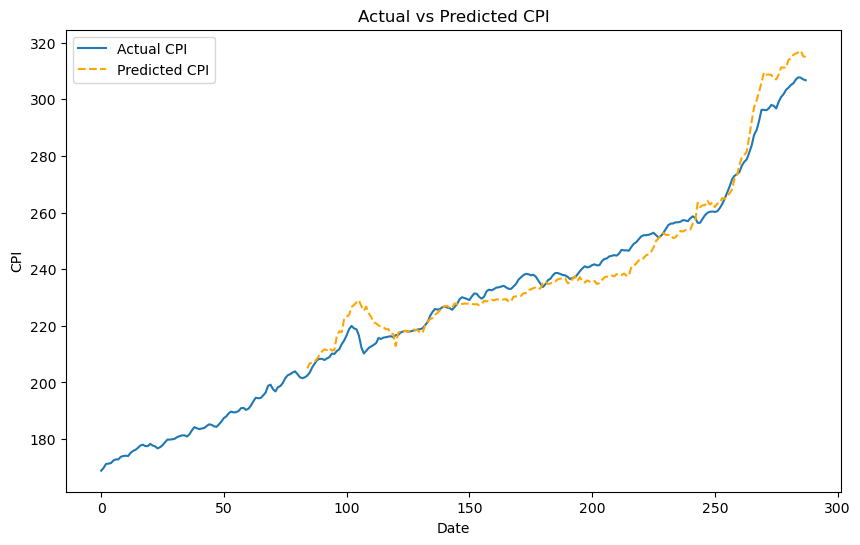

In [64]:
#Level 5
level5_df = df[df['display_level']==5][["month","item_name","value"]]
level5_df = level5_df[["month","item_name","value"]].pivot_table(index = "month", columns="item_name",values="value")
level5_df = level5_df.fillna(0)

cpi_indicators = level5_df[level5_df.columns]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

In [90]:
#Level 6
level6_df = df[df['display_level']==6][["month","item_name","value"]]
level6_df = level6_df[["month","item_name","value"]].pivot_table(index = "month", columns="item_name",values="value")
level6_df = level6_df.fillna(0)

cpi_indicators = level6_df[level6_df.columns]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

TypeError: choose_num_components() missing 1 required positional argument: 'variance_threshold'

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\1270754896.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 6.821078710456961


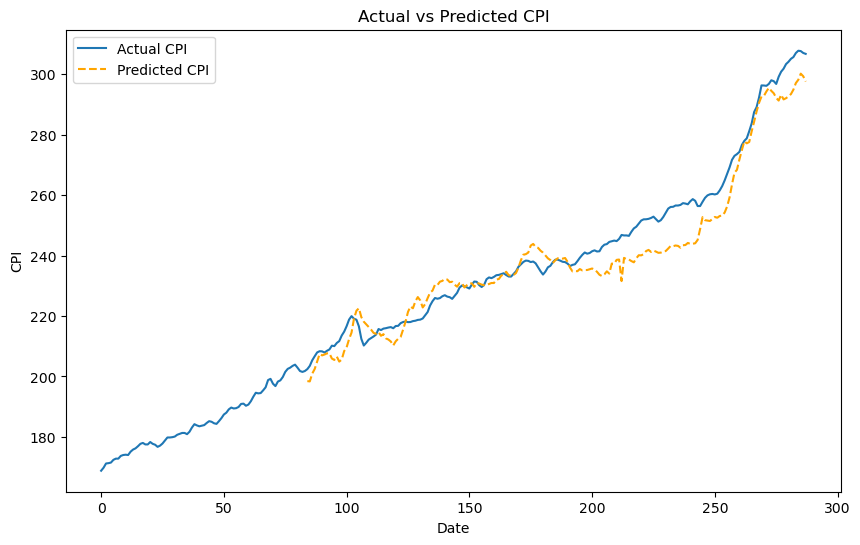

In [92]:
#Level 7
level7_df = df[df['display_level']==7][["month","item_name","value"]]
level7_df = level7_df[["month","item_name","value"]].pivot_table(index = "month", columns="item_name",values="value")
level7_df = level7_df.fillna(0)

cpi_indicators = level7_df[level7_df.columns]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\1522675875.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 9.868060707648368


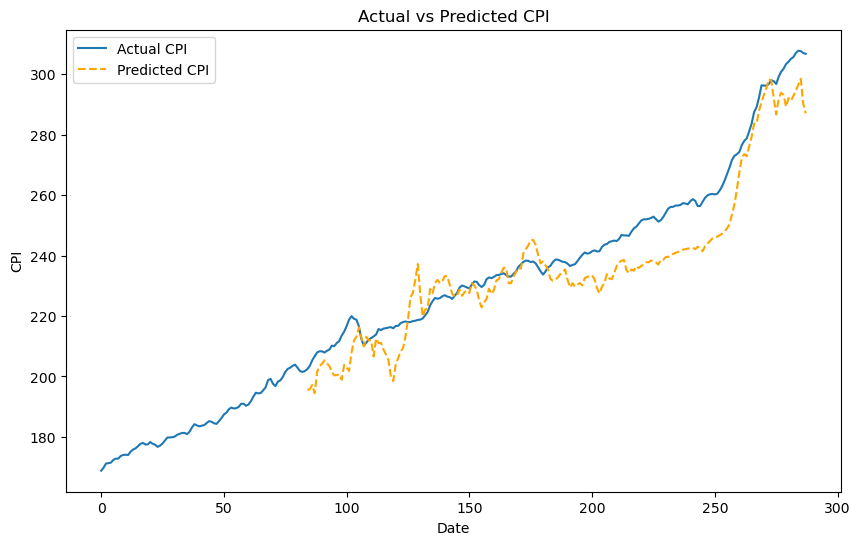

In [93]:
#Level 8
level8_df = df[df['display_level']==8][["month","item_name","value"]]
level8_df = level8_df[["month","item_name","value"]].pivot_table(index = "month", columns="item_name",values="value")
level8_df = level8_df.fillna(0)

cpi_indicators = level8_df[level8_df.columns]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

WITH MACROECONOMICS

In [6]:
df

year    month         seriesID  \
0       2000  2000-01      CUUR0000SA0   
1       2000  2000-01      CUUR0000SAA   
2       2000  2000-01     CUUR0000SAA1   
3       2000  2000-01     CUUR0000SAA2   
4       2000  2000-01      CUUR0000SAC   
...      ...      ...              ...   
167055  2023  2023-12  CUUR0000SS62032   
167056  2023  2023-12  CUUR0000SS62053   
167057  2023  2023-12  CUUR0000SS62054   
167058  2023  2023-12  CUUR0000SS62055   
167059  2023  2023-12  CUUR0000SS68021   

                                               item_name  display_level  \
0                                              All items              0   
1                                                Apparel              0   
2                                Men's and boys' apparel              1   
3                             Women's and girls' apparel              1   
4                                            Commodities              1   
...                                                  ...            ...   
167055                      Admission to sporting events              3   
167056                                      Pet services              3   
167057                             Veterinarian services              3   
167058  Subscription and rental of video and video games              3   
167059          Checking account and other bank services              4   

         value       unadjusted  
0       168.80      CUUR0000SA0  
1       126.80      CUUR0000SAA  
2       129.20     CUUR0000SAA1  
3       116.00     CUUR0000SAA2  
4       146.20      CUUR0000SAC  
...        ...              ...  
167055  263.85  CUUR0000SS62032  
167056  232.51  CUUR0000SS62053  
167057  356.12  CUUR0000SS62054  
167058  157.02  CUUR0000SS62055  
167059  183.60  CUUR0000SS68021  

[167060 rows x 7 columns]

In [39]:
macro_df = pd.read_csv("C:\\Users\\nguye\\OneDrive\\Documents\\Python Scripts\\masterthesis\\macro.csv").iloc[1:]
macro_df["sasdate"] = pd.to_datetime(macro_df["sasdate"],format="%m/%d/%Y")
macro_df = macro_df[macro_df["sasdate"]>="2000-01-01"]

macro_df["year"] = macro_df["sasdate"].dt.year
macro_df["month"] = macro_df["sasdate"].dt.strftime("%Y-%m")
columns = macro_df.columns[-2:].append(macro_df.columns[1:-2])
macro_df = macro_df[columns].reset_index(drop = True)
var_list = macro_df.columns[2:]
macro_df = macro_df.groupby(["year", "month"])[var_list].sum().reset_index()
macro_df

year    month        RPI  W875RX1  DPCERA3M086SBEA  CMRMTSPLx   RETAILx  \
0    2000  2000-01  11441.669  10000.3           67.481  1069375.0  268044.0   
1    2000  2000-02  11488.814  10045.9           68.116  1050132.0  272020.0   
2    2000  2000-03  11520.777  10078.6           68.451  1062548.0  275192.0   
3    2000  2000-04  11582.719  10127.6           68.431  1071378.0  271046.0   
4    2000  2000-05  11624.340  10135.7           68.688  1065692.0  271394.0   
..    ...      ...        ...      ...              ...        ...       ...   
283  2023  2023-08  19098.603  15707.7          116.171  1497717.0  699540.0   
284  2023  2023-09  19088.877  15719.1          116.594  1507530.0  705304.0   
285  2023  2023-10  19134.088  15766.4          116.583  1505904.0  703528.0   
286  2023  2023-11  19220.584  15863.0          117.115  1518957.0  705981.0   
287  2023  2023-12  19237.854  15886.5          117.749        0.0  709890.0   

       INDPRO   IPFPNSS   IPFINAL  ...  DNDGRG3M086SBEA  DSERRG3M086SBEA  \
0     91.4251   99.2881   96.4854  ...           74.551           64.396   
1     91.7357   99.7716   97.0728  ...           75.092           64.588   
2     92.0933   99.9960   97.1835  ...           76.053           64.703   
3     92.6838  100.8222   97.9926  ...           75.746           64.732   
4     92.9376  100.9574   98.3039  ...           75.613           64.856   
..        ...       ...       ...  ...              ...              ...   
283  103.2411  101.4468  101.9571  ...          120.012          123.370   
284  103.3346  101.2042  101.5822  ...          120.395          123.976   
285  102.4592  100.4656  100.5505  ...          120.011          124.214   
286  102.4301  100.5157  100.8247  ...          118.953          124.539   
287  102.4840  100.5301  100.9359  ...          118.879          124.963   

     CES0600000008  CES2000000008  CES3000000008  UMCSENTx  DTCOLNVHFNM  \
0            15.01          17.11          14.13     112.0    132467.09   
1            15.06          17.20          14.14     111.3    136610.16   
2            15.10          17.28          14.17     107.1    136745.97   
3            15.17          17.39          14.23     109.2    136863.39   
4            15.17          17.38          14.23     110.7    140410.20   
..             ...            ...            ...       ...          ...   
283          29.74          34.45          26.50      69.4    504406.44   
284          29.90          34.54          26.64      67.9    508808.61   
285          29.98          34.64          26.70      63.8    512056.53   
286          30.23          34.94          26.91      61.3    515110.84   
287          30.38          34.92          27.16       0.0         0.00   

      DTCTHFNM     INVEST  VIXCLSx  
0    421056.34  1147.2425  24.8430  
1    422437.48  1140.6128  25.4560  
2    423323.75  1153.5602  24.7678  
3    427912.64  1159.8397  29.8331  
4    432485.03  1164.5086  29.4290  
..         ...        ...      ...  
283  910966.86  5111.5017  15.7822  
284  913938.95  5074.6667  15.0424  
285  916941.34  5015.7795  19.0462  
286  919957.82  5003.5829  13.8563  
287       0.00  5085.0280  12.6960  

[288 rows x 129 columns]

In [48]:
#Level 0
level0_df_macro = level0_df.merge(macro_df, on = ["month"])
cpi_values = level0_df_macro[['All items']]

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\1976015573.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 2
Root Mean Squared Error (RMSE): 5.026190541527054


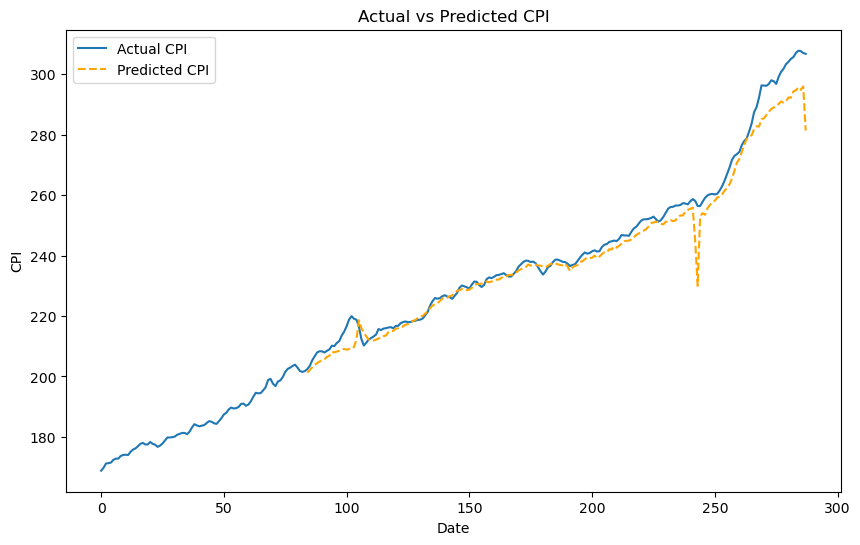

In [80]:
cpi = level0_df_macro[["All items"]]
cpi_indicators = level0_df_macro[level0_df_macro.columns[2:]]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\3441257893.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 4.0591230736012465


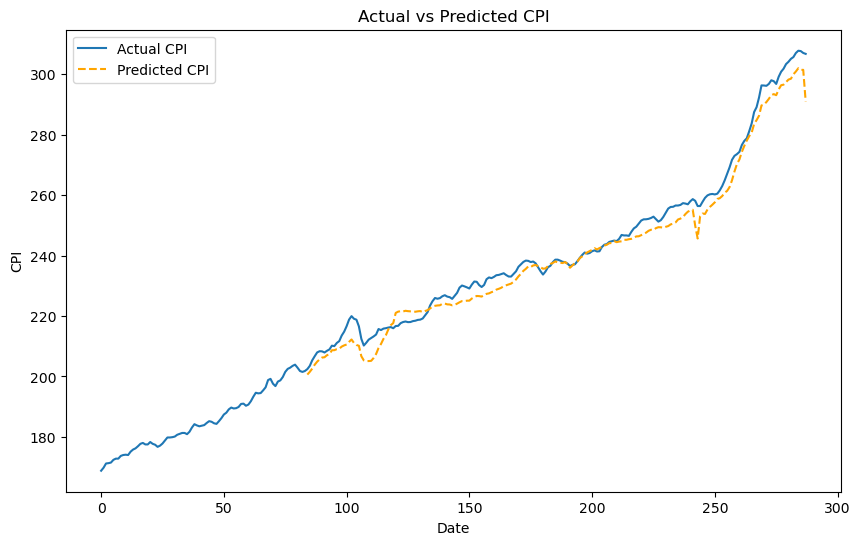

In [79]:
#Level 1
level1_df_macro = level1_df.merge(macro_df, on = ["month"])

cpi_indicators = level1_df_macro[level1_df_macro.columns[2:]]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\2533249703.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 4.212480554177718


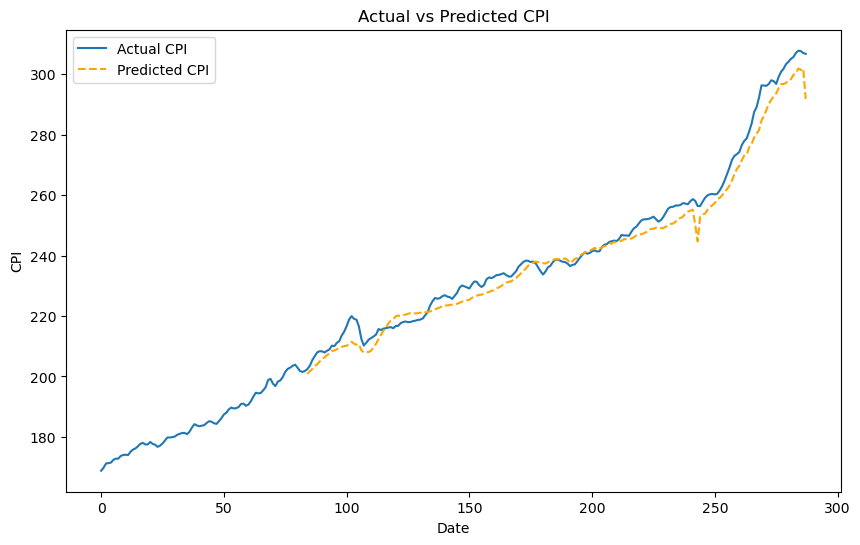

In [78]:
#Level 2
level2_df_macro = level2_df.merge(macro_df, on = ["month"])

cpi_indicators = level2_df_macro[level2_df_macro.columns[2:]]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\1895116835.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 3.6633721215716655


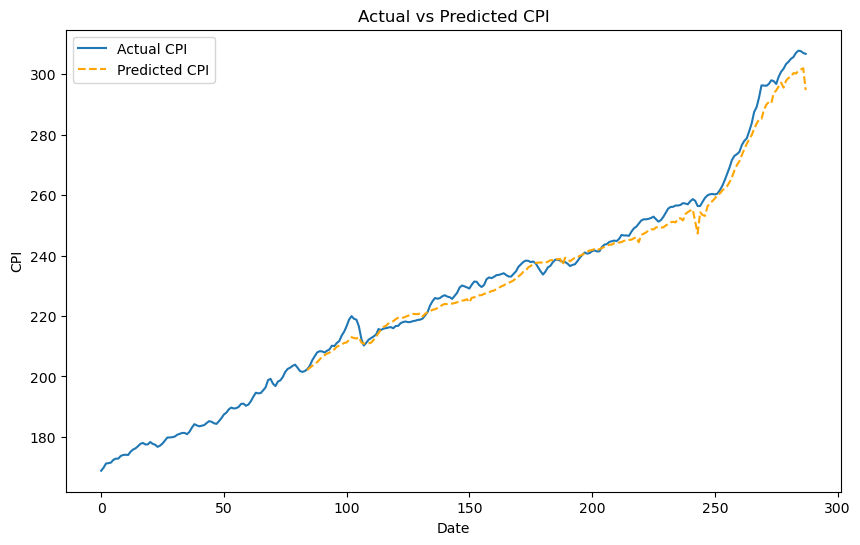

In [81]:
#Level 3
level3_df_macro = level3_df.merge(macro_df, on = ["month"])

cpi_indicators = level3_df_macro[level3_df_macro.columns[2:]]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\341111653.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 3.8390829155908284


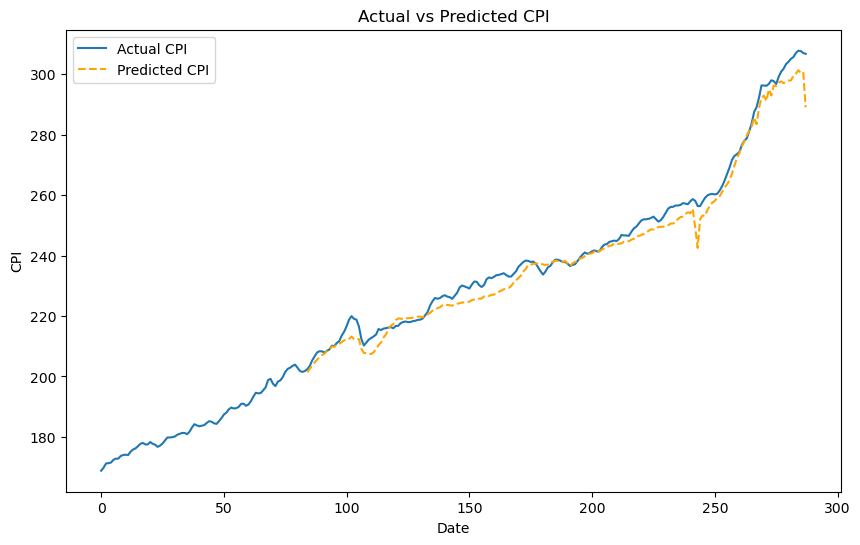

In [85]:
#Level 4
level4_df_macro = level4_df.merge(macro_df, on = ["month"])

cpi_indicators = level4_df_macro[level4_df_macro.columns[2:]]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\1183938757.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 3.7293835243571887


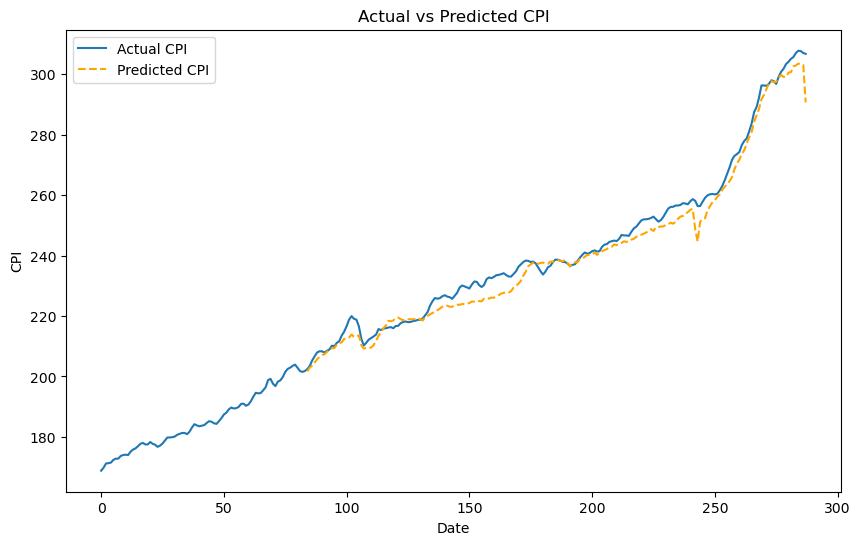

In [94]:
#Level 5
level5_df_macro = level5_df.merge(macro_df, on = ["month"])

cpi_indicators = level5_df_macro[level5_df_macro.columns[2:]]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\2189748736.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 1
Root Mean Squared Error (RMSE): 3.7293835243571887


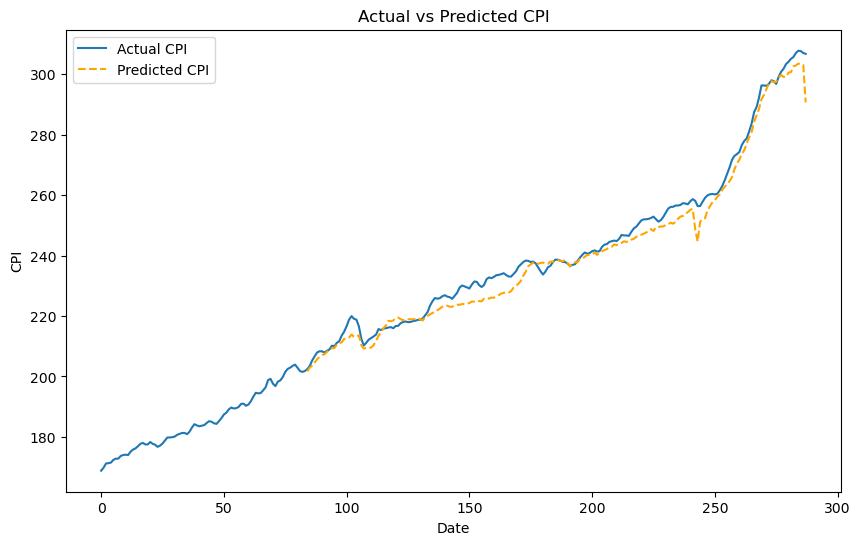

In [95]:
#Level 6
level6_df_macro = level6_df.merge(macro_df, on = ["month"])

cpi_indicators = level6_df_macro[level6_df_macro.columns[2:]]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\4281615990.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 2
Root Mean Squared Error (RMSE): 4.8909746537121235


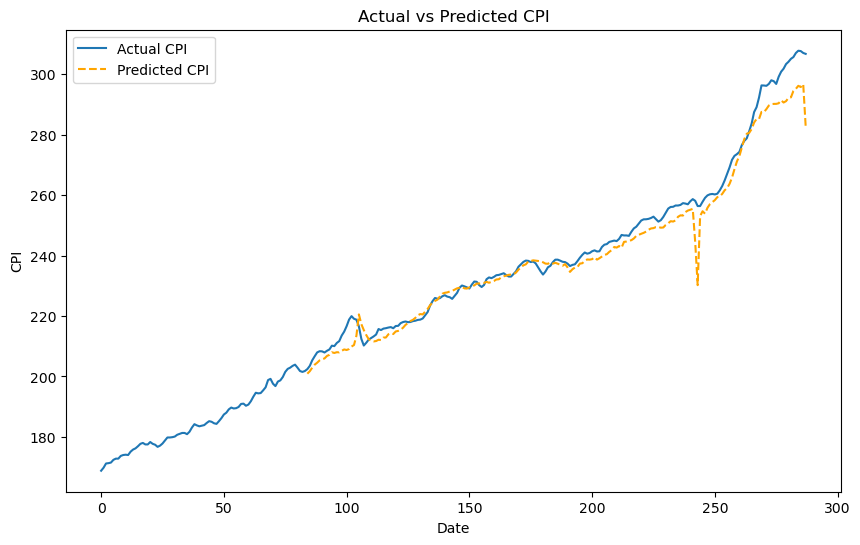

In [96]:
#Level 7
level7_df_macro = level7_df.merge(macro_df, on = ["month"])

cpi_indicators = level7_df_macro[level7_df_macro.columns[2:]]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

C:\Users\nguye\AppData\Local\Temp\ipykernel_23776\2669536492.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series(index=y.index)


Chosen Number of Principal Components: 2
Root Mean Squared Error (RMSE): 5.508450139478494


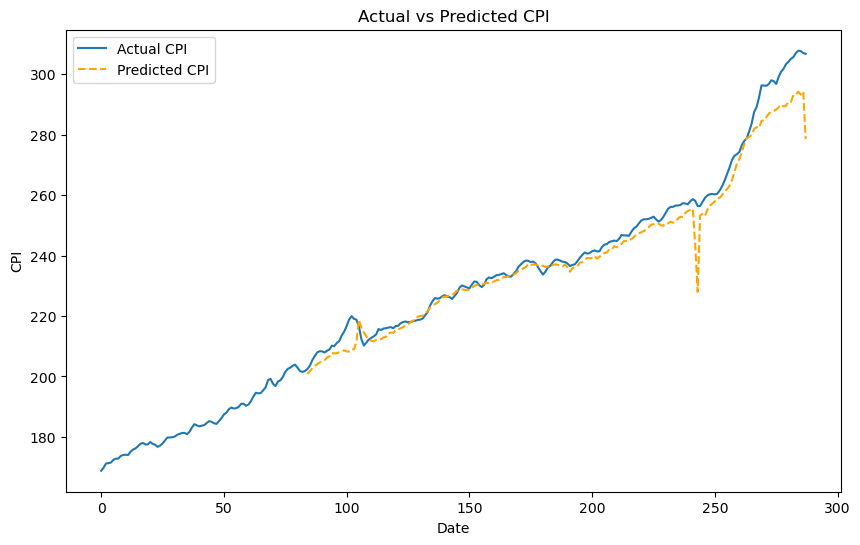

In [97]:
#Level 8
level8_df_macro = level8_df.merge(macro_df, on = ["month"])

cpi_indicators = level8_df_macro[level8_df_macro.columns[2:]]

window_size = 7 * 12  # 7 years of monthly data
forecast_horizon = 12  # 12 months forecast

# Choose the number of principal components
num_components = choose_num_components(cpi_indicators,variance_threshold)

# Perform sliding window forecast using PCA
# predicted_values = sliding_window_pca_forecast(cpi_indicators, cpi, window_size, forecast_horizon, num_components)
X = cpi_indicators
y=cpi
predictions = pd.Series(index=y.index)
for i in range(len(X) - window_size - forecast_horizon + 1):
        # Extract the training data for the current window
        train_X = X.iloc[i:i+window_size, :]
        train_y = y.iloc[i:i+window_size]
        
        # Apply PCA for dimensionality reduction on X
        pca = make_pipeline(StandardScaler(), PCA(n_components=num_components))
        pca.fit(train_X)
        reduced_train_X = pca.transform(train_X)
        
        # Fit a linear regression model on the reduced X
        model = LinearRegression()
        model.fit(reduced_train_X, train_y)
        
        # Forecast the next 'forecast_horizon' months
        forecast_X = X.iloc[i+window_size:i+window_size+forecast_horizon, :]
        
        # Apply PCA to forecast X
        reduced_forecast_X = pca.transform(forecast_X)
        
        # Predict the values using the linear regression model
        forecast_predictions = model.predict(reduced_forecast_X)
        
         # Append the predictions to the result Series
        forecast_dates = y.index[i+window_size:i+window_size+forecast_horizon]
        predictions.loc[forecast_dates] = forecast_predictions.flatten()  # Flatten the array for proper assignment


# Calculate RMSE
rmse = sqrt(mean_squared_error(cpi.iloc[85:], predictions.iloc[85:]))

# Print the chosen number of components and RMSE
print("Chosen Number of Principal Components:", num_components)
print("Root Mean Squared Error (RMSE):", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cpi.index, cpi, label='Actual CPI')
plt.plot(predictions.index, predictions, label='Predicted CPI', linestyle='dashed', color='orange')
plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()